# Step 1: Load, normalise, and filter LLM data
### This turns it into the dataframe llm_data

In [5]:
import pandas as pd
import sqlite3
import yaml
from datetime import datetime

# Load configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Connect to the SQLite database
conn = sqlite3.connect(config['db_path'])

# Read data from the 'events' table
query = "SELECT * FROM events"
llm_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Function to parse dates in 'DD.MM.YY' format
def parse_date(date_string):
    if pd.isna(date_string) or (isinstance(date_string, str) and date_string.strip() == ""):
        return pd.NaT
    try:
        # Convert the date_string to a string
        date_str = str(date_string)
        
        # Assume two-digit years up to 99 are in the 20th century
        year = int(date_str[-2:])
        if year <= 99:
            year += 1900
        date_str = f"{date_str[:-2]}{year}"
        return datetime.strptime(date_str, '%d.%m.%Y')
    except ValueError:
        return pd.NaT



# Normalize the date column
llm_data['normalized_date'] = llm_data['konsert_datum'].apply(parse_date)

#llm_data = llm_data[llm_data['normalized_date'].notna()]  # Remove rows with invalid dates

# Normalize the 'konsert_namn' field
llm_data['normalized_konsert_namn'] = llm_data['konsert_namn'].str.strip().str.lower()

# Identify and remove duplicates, understood as having the same name and date
duplicates = llm_data.duplicated(subset=['normalized_date', 'normalized_konsert_namn'], keep=False)
unique_data = llm_data[~duplicates]
duplicate_data = llm_data[duplicates]

# Combine discarded entries
combined_discards = pd.concat([duplicate_data, llm_data[llm_data['normalized_date'].isna()]])

# Save the discarded entries
today_date = pd.Timestamp.now().strftime('%Y-%m-%d')
combined_discards.to_json(f'Cleaning/{today_date}_rejected_step_1.json', orient='records', force_ascii=False)

# Ensure 'producer' column exists (it's lowercase in the database)
if 'producer' not in llm_data.columns:
    llm_data['producer'] = ''

# Get the columns to compare from the config
columns_to_compare = config['columns_to_compare']
llm_data = unique_data[columns_to_compare].copy()

# Normalize text in all columns
def normalize_text(text):
    if pd.isna(text) or str(text).strip().lower() == "unknown":
        return ""
    return ' '.join(str(text).lower().split())

llm_data = llm_data.applymap(normalize_text)

# Display the result
display(llm_data.head(5))


/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_40972/4122853100.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  llm_data = llm_data.applymap(normalize_text)


,normalized_date,normalized_konsert_namn,lokal_namn
0,1908-02-19 00:00:00,mäster olof,kungliga dramatiska teatern
2,,,
3,1908-02-15 00:00:00,fru ebba sjögren vis- och sagoafton,vetenskapsakademiens hörsal
4,1908-02-17 00:00:00,konsert för sthlms arbetaresångförening,k. musikaliska akademiens stora sal
6,,middagskonsert,berns


# Import Human Data

In [6]:
from datetime import datetime

human_data = pd.read_excel(config['Stockholm_Concert_Database_Path'])

#Function to convert date objects in the human data
def convert_human_dates(date_obj):
    if isinstance(date_obj, str):
        # If the input is a string, parse it
        try:
            date = datetime.strptime(date_obj, "%Y-%m-%d")
        except ValueError:
            # Return None if the input string is invalid
            return None
    elif isinstance(date_obj, pd.Timestamp):
        # If the input is a Timestamp object, convert it to datetime
        date = date_obj.to_pydatetime()
    else:
        # Return None if the input is neither a string nor a Timestamp
        return None
    
    # Convert to the desired format
    formatted_date = date.strftime("%Y-%m-%d 00:00:00")
    
    return formatted_date

# Normalise the date column by applying the convert_human_dates function to the 'konsert_datum' column
human_data['normalized_date'] = human_data['konsert_datum'].apply(convert_human_dates)

# Drop the original 'konsert_datum' column
human_data = human_data.drop('konsert_datum', axis=1)

# Remove rows with invalid dates in the 'normalized_date' column
human_data = human_data[human_data['normalized_date'].notna()]

# Normalize the 'konsert_namn' field
human_data['normalized_konsert_namn'] = human_data['konsert_namn'].str.strip().str.lower()

# Normalize text in all columns
def normalize_text(text):
    if pd.isna(text) or str(text).strip().lower() == "unknown":
        return ""
    return ' '.join(str(text).lower().split())

human_data = human_data.applymap(normalize_text)

# Display the result
display(human_data.head(10))

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_40972/2516436418.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  human_data = human_data.applymap(normalize_text)


,konsert_ID,konsert_namn,lokal_namn,konsert_biljettpris,SummaförAnnons/program,SummaförRecension,SummaförAntalförkonsert_verk_ID,Arrangör,konserttyp_namn,Månad,År,Dag,Månadnr,lokal_namn_eng,konserttyp_namn_eng,Producer,normalized_date,normalized_konsert_namn
0,2528,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal,,,,,brüssel-stråkkvartetten,kammarmusikkonsert,january,1908,thursday,1,,chamber music concert,brüssel-stråkkvartetten - brussels string quartet,1908-01-02 00:00:00,brüssel-kvartetten beethovenafton
1,2509,1:sta säsångskonsert: nordisk afton,hotel continentals festsal,"2kr (numrerade platser), 1:50kre och 1kr",2.0,,14.0,"gellin, eduard",konsert,january,1908,sunday,1,,concert,"gellin, eduard",1908-01-05 00:00:00,1:sta säsångskonsert: nordisk afton
2,2521,afskedskonsert,immanuelskyrkan,,,2.0,,"bohlin, carl. direktör",kyrkokonsert,january,1908,sunday,1,,church concert,"bohlin, carl. director",1908-01-05 00:00:00,afskedskonsert
3,2516,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8",,2.0,,5.0,,folkkonsert,january,1908,sunday,1,,folk concert,,1908-01-05 00:00:00,folk-konsert
4,2515,populärkonsert,vetenskapsakademiens hörsal,,,,,"hansson, axel",populärkonsert,january,1908,sunday,1,,popular concert,"hansson, axel",1908-01-05 00:00:00,populärkonsert
5,2510,2:a populära symfoni-matinéen,berns salong,"1kr till salongen, 1:50kr till läktaren",,2.0,,berns,konsert,january,1908,monday,1,,concert,berns,1908-01-06 00:00:00,2:a populära symfoni-matinéen
6,2511,jul-fest med bal,grand restaurant nationals stora salong,"1:25kr herre, 1kr da, 50öre barn",,,,lj. b.,bal,january,1908,monday,1,,ball,lj. b.,1908-01-06 00:00:00,jul-fest med bal
7,2517,populär soaré,vetenskapsakademiens hörsal,"1kr reserverad plats, 75öre övriga platser",1.0,,9.0,"dahlberg, erik",populärkonsert,january,1908,monday,1,,popular concert,"dahlberg, erik",1908-01-06 00:00:00,populär soaré
8,2519,populär soaré,"arbetare-institutet, klara norra kyrkogata 8","1kr reserverad plats, 75öre, 50öre",,,,arbetareinstitutet,populärkonsert,january,1908,monday,1,,popular concert,arbetareinstitutet - workers' institute,1908-01-06 00:00:00,populär soaré
9,2512,2:a kammarmusikkonsert: brahmsafton,vetenskapsakademiens hörsal,"3kr numrerade, 2:50kr onumrerade",3.0,2.0,3.0,aulinkvartetten,kammarmusikkonsert,january,1908,tuesday,1,,chamber music concert,aulinkvartetten - aulin quartet,1908-01-07 00:00:00,2:a kammarmusikkonsert: brahmsafton


In [11]:
# Dropping everything in human data except the required columns

# Create a list of required columns
required_columns = columns_to_compare + ['normalized_date']

# Drop all columns except for the required columns
human_data = human_data[required_columns]

human_data = human_data.loc[:, ~human_data.columns.duplicated()]


# Display the result
display(human_data.head(5))


,normalized_date,normalized_konsert_namn,lokal_namn
0,1908-01-02 00:00:00,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal
1,1908-01-05 00:00:00,1:sta säsångskonsert: nordisk afton,hotel continentals festsal
2,1908-01-05 00:00:00,afskedskonsert,immanuelskyrkan
3,1908-01-05 00:00:00,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8"
4,1908-01-05 00:00:00,populärkonsert,vetenskapsakademiens hörsal


In [14]:
print(llm_data.columns.duplicated())


[False False False  True]


# Cleaning the two datasets for comparison

In [17]:
from IPython.display import display

import pandas as pd
import numpy as np

# Ensure both DataFrames only have the columns to compare and normalized_date
required_columns = columns_to_compare + ['normalized_date']
assert all(col in llm_data.columns for col in required_columns), "Missing required columns in llm_data"
assert all(col in human_data.columns for col in required_columns), "Missing required columns in human_data"

llm_data = llm_data[required_columns]
human_data = human_data[required_columns]

# Remove duplicate columns if they exist
llm_data = llm_data.loc[:, ~llm_data.columns.duplicated()]
human_data = human_data.loc[:, ~human_data.columns.duplicated()]

# Ensure the 'normalized_date' column is 1-dimensional and properly formatted
llm_data['normalized_date'] = pd.to_datetime(llm_data['normalized_date'], errors='coerce')
human_data['normalized_date'] = pd.to_datetime(human_data['normalized_date'], errors='coerce')

# Drop rows with invalid 'normalized_date' values
human_data = human_data.dropna(subset=['normalized_date'])

display(llm_data)
display(human_data)


,normalized_date,normalized_konsert_namn,lokal_namn
0,1908-02-19,mäster olof,kungliga dramatiska teatern
2,NaT,,
3,1908-02-15,fru ebba sjögren vis- och sagoafton,vetenskapsakademiens hörsal
4,1908-02-17,konsert för sthlms arbetaresångförening,k. musikaliska akademiens stora sal
6,NaT,middagskonsert,berns
7,NaT,nior konsert,svea-salen
8,1908-02-15,nior konsert,svea-salen
9,1908-02-17,kalle- och afton-konsert,arbetareinstitutet
10,1908-02-16,skandinavisk romansafton,nan
11,1908-02-08,lördags-konsert,vetenskapsakademiens hörsal


,normalized_date,normalized_konsert_namn,lokal_namn
0,1908-01-02,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal
1,1908-01-05,1:sta säsångskonsert: nordisk afton,hotel continentals festsal
2,1908-01-05,afskedskonsert,immanuelskyrkan
3,1908-01-05,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8"
4,1908-01-05,populärkonsert,vetenskapsakademiens hörsal
...,...,...,...
509,1908-12-26,familje-soiré,vetenskapsakademiens hörsal
510,1908-12-26,populär soaré,"arbetare-institutet, klara norra kyrkogata 8"
511,1908-12-27,populär soaré,"arbetare-institutet, klara norra kyrkogata 8"
512,1908-12-31,nyårsvaka å runan,


# Human_Data: Comparing every row of human_data to LLM to find best match

In [22]:
from fuzzywuzzy import fuzz
# Function to compute the maximum fuzzy match score and index for a given row against a group of rows
def compute_fuzzy_match_with_date(row1_str, date_group, group_indices):
    max_score = 0
    best_index = None
    for idx, row2_str in zip(group_indices, date_group):
        score = fuzz.token_set_ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
            best_index = idx
    return (max_score if max_score > 0 else np.nan, best_index)

# Preprocess llm_data to group by 'normalized_date'
date_groups = llm_data.groupby('normalized_date').apply(
    lambda df: (
        [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()],
        df.index.tolist()
    )
)

# Compute match scores and best match indices for each row in human_data
human_data['match_score'], human_data['best_match_index'] = zip(*human_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        *date_groups.get(row['normalized_date'], ([], []))
    ),
    axis=1
))

# Sort human_data by 'match_score' in descending order
sorted_human_data = human_data.sort_values(by='match_score', ascending=False)

# Display the relevalt columns
display(sorted_human_data[['match_score', 'best_match_index']])

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_40972/513110085.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = llm_data.groupby('normalized_date').apply(


,match_score,best_match_index
84,97.0,3.0
78,96.0,13.0
86,95.0,10.0
82,91.0,17.0
73,88.0,11.0
...,...,...
509,NaN,NaN
510,NaN,NaN
511,NaN,NaN
512,NaN,NaN


# Statistics for the Human_data, detailing how close a match in the LLM data has been found

#### Best score so far is 69.75 achieved by comparing 'normalized_date', 'normalized_konsert_namn', 'lokal_namn', so if it's lower than that then you better have a good reason

Average of 'match_score': 65.56521739130434
25th Percentile of 'match_score': 51.5
Median (50th Percentile) of 'match_score': 64.0
75th Percentile of 'match_score': 80.5
Median of 'match' score': 64.0
Standard Deviation of 'match_score': 18.992405388749283


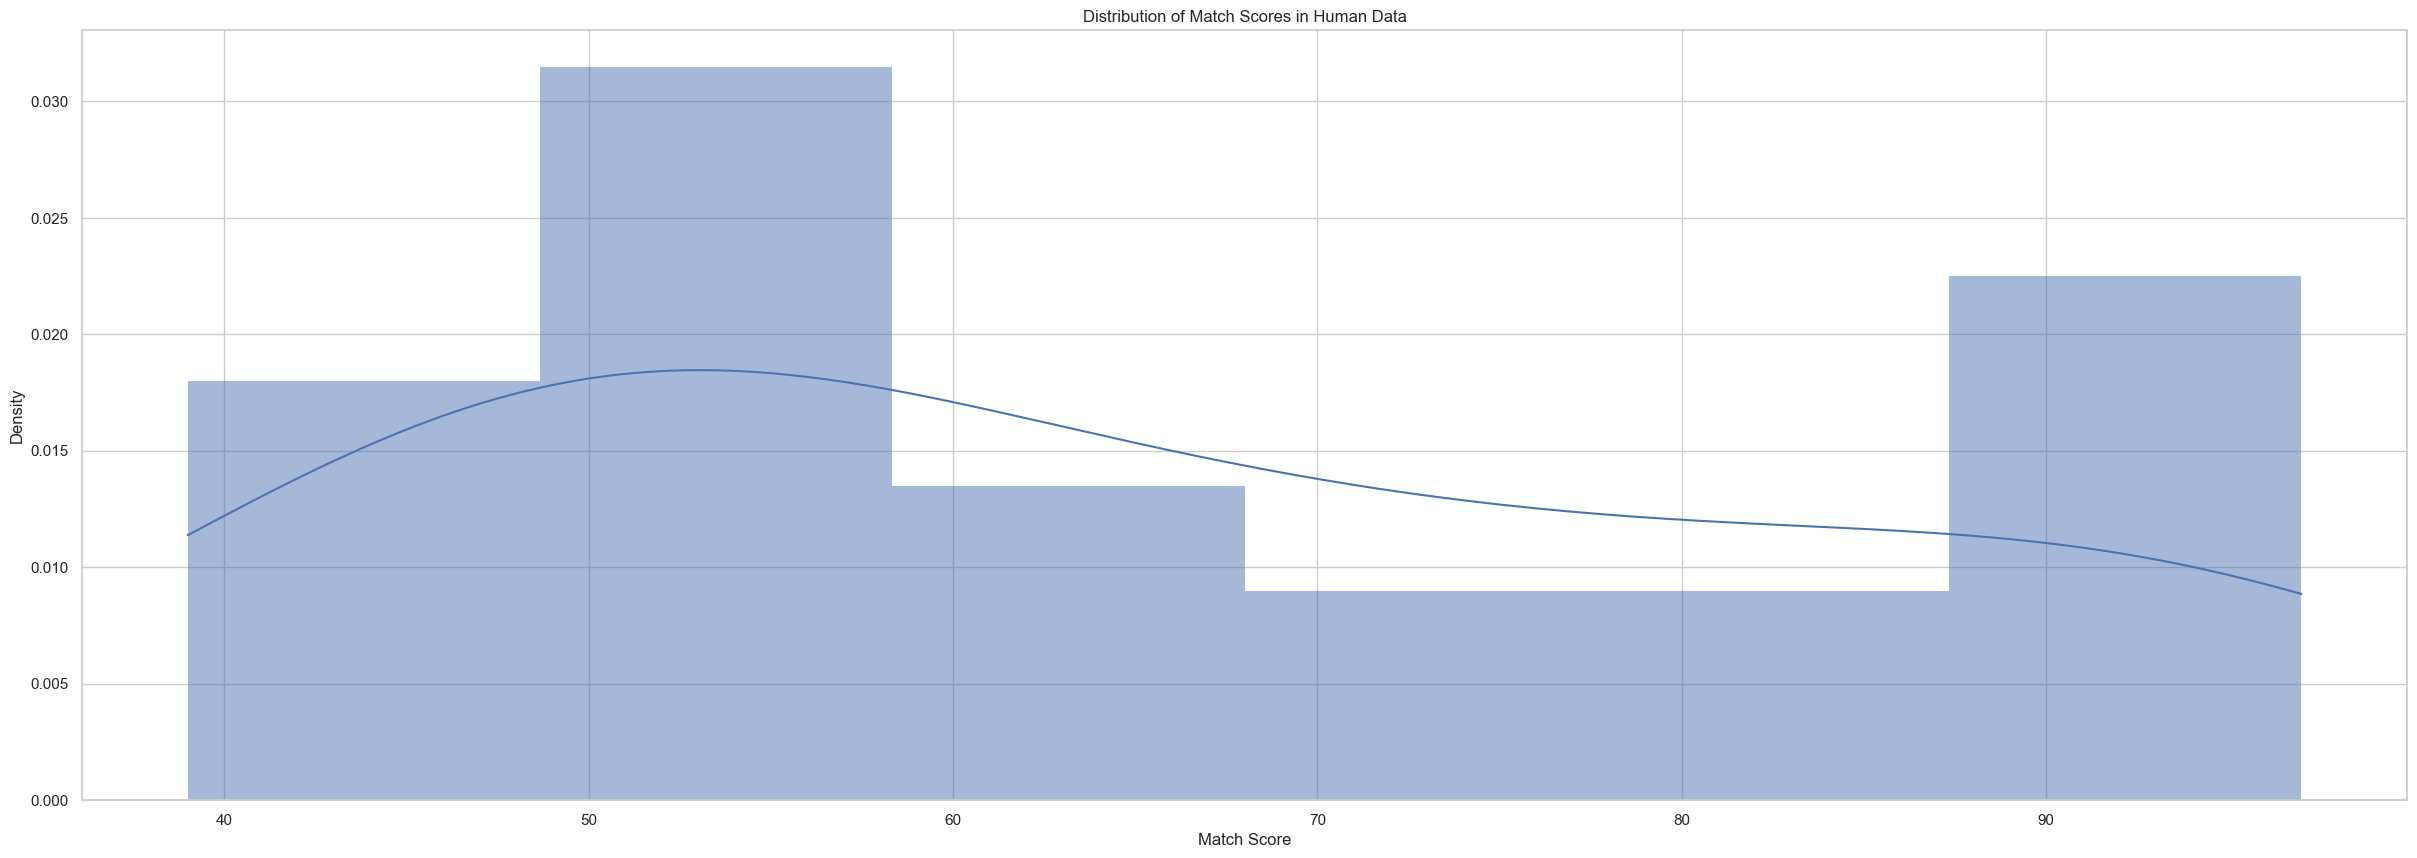

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the standard deviation of the 'match_score' column in human_data
std_deviation = human_data['match_score'].std()

# Calculate the average of the 'match_score' column in human_data
average_match_score = human_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column in human_data
percentile_25 = human_data['match_score'].quantile(0.25)
percentile_50 = human_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = human_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column in human_data
median_match_score = human_data['match_score'].median()

# Print the median match score
print("Median of 'match' score':", median_match_score)

# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)

# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot for match_score distribution in human_data
plt.figure(figsize=(30, 10))
sns.histplot(human_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores in Human Data')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()


# Statistics for comparisons finding best human_data match for LLM data

In [20]:
# Calculate the standard deviation of the 'match_score' column
std_deviation = llm_data['match_score'].std()

# Calculate the average of the 'match_score' column
average_match_score = llm_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column
percentile_25 = llm_data['match_score'].quantile(0.25)
percentile_50 = llm_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = llm_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column
median_match_score = llm_data['match_score'].median()

# Print the median match score
print("Median of 'match_score':", median_match_score)


# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)


KeyError: 'match_score'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot
plt.figure(figsize=(30, 10))
sns.histplot(llm_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()